# Machine Learning and AI for Autonomous Systems
## A program by IISc and TalentSprint
### Assignment: Proximal Policy Optimization

## Learning Objectives

At the end of the experiment, you will be able to :

* understand Proximal Policy Optimization
* implement Proximal Policy Optimization to solve Super-Mario-Bros environment

### Setup Steps:

In [1]:
#@title Please enter your registration id to start: { run: "auto", display-mode: "form" }
Id = "2302794" #@param {type:"string"}

In [2]:
#@title Please enter your password (your registered phone number) to continue: { run: "auto", display-mode: "form" }
password = "9008710123" #@param {type:"string"}

In [3]:
#@title Run this cell to complete the setup for this Notebook
from IPython import get_ipython

ipython = get_ipython()

notebook= "AIAS_B2_M4_AST_10_Proximal_Policy_Optimization_C" #name of the notebook

def setup():
#  ipython.magic("sx pip3 install torch")
    from IPython.display import HTML, display
    display(HTML('<script src="https://dashboard.talentsprint.com/aiml/record_ip.html?traineeId={0}&recordId={1}"></script>'.format(getId(),submission_id)))
    print("Setup completed successfully")
    return

def submit_notebook():
    ipython.magic("notebook -e "+ notebook + ".ipynb")

    import requests, json, base64, datetime

    url = "https://dashboard.talentsprint.com/xp/app/save_notebook_attempts"
    if not submission_id:
      data = {"id" : getId(), "notebook" : notebook, "mobile" : getPassword()}
      r = requests.post(url, data = data)
      r = json.loads(r.text)

      if r["status"] == "Success":
          return r["record_id"]
      elif "err" in r:
        print(r["err"])
        return None
      else:
        print ("Something is wrong, the notebook will not be submitted for grading")
        return None

    elif getAnswer() and getComplexity() and getAdditional() and getConcepts() and getComments() and getMentorSupport():
      f = open(notebook + ".ipynb", "rb")
      file_hash = base64.b64encode(f.read())

      data = {"complexity" : Complexity, "additional" :Additional,
              "concepts" : Concepts, "record_id" : submission_id,
              "answer" : Answer, "id" : Id, "file_hash" : file_hash,
              "notebook" : notebook,
              "feedback_experiments_input" : Comments,
              "feedback_mentor_support": Mentor_support}
      r = requests.post(url, data = data)
      r = json.loads(r.text)
      if "err" in r:
        print(r["err"])
        return None
      else:
        print("Your submission is successful.")
        print("Ref Id:", submission_id)
        print("Date of submission: ", r["date"])
        print("Time of submission: ", r["time"])
        print("View your submissions: https://aias-iisc.talentsprint.com/notebook_submissions")
        #print("For any queries/discrepancies, please connect with mentors through the chat icon in LMS dashboard.")
        return submission_id
    else: submission_id


def getAdditional():
  try:
    if not Additional:
      raise NameError
    else:
      return Additional
  except NameError:
    print ("Please answer Additional Question")
    return None

def getComplexity():
  try:
    if not Complexity:
      raise NameError
    else:
      return Complexity
  except NameError:
    print ("Please answer Complexity Question")
    return None

def getConcepts():
  try:
    if not Concepts:
      raise NameError
    else:
      return Concepts
  except NameError:
    print ("Please answer Concepts Question")
    return None


# def getWalkthrough():
#   try:
#     if not Walkthrough:
#       raise NameError
#     else:
#       return Walkthrough
#   except NameError:
#     print ("Please answer Walkthrough Question")
#     return None

def getComments():
  try:
    if not Comments:
      raise NameError
    else:
      return Comments
  except NameError:
    print ("Please answer Comments Question")
    return None


def getMentorSupport():
  try:
    if not Mentor_support:
      raise NameError
    else:
      return Mentor_support
  except NameError:
    print ("Please answer Mentor support Question")
    return None

def getAnswer():
  try:
    if not Answer:
      raise NameError
    else:
      return Answer
  except NameError:
    print ("Please answer Question")
    return None


def getId():
  try:
    return Id if Id else None
  except NameError:
    return None

def getPassword():
  try:
    return password if password else None
  except NameError:
    return None

submission_id = None
### Setup
if getPassword() and getId():
  submission_id = submit_notebook()
  if submission_id:
    setup()
else:
  print ("Please complete Id and Password cells before running setup")



Setup completed successfully


## Information

**Proximal Policy Optimization (PPO) algorithm**

It combines ideas from A2C (having multiple workers) and TRPO (uses a trust region to improve the actor). The main idea is that after an update, the new policy should be not too far from the old policy. For that, PPO uses clipping to avoid too large update.

To know more about PPO algorithm, refer [here](https://spinningup.openai.com/en/latest/algorithms/ppo.html).
<br><br>

Here, we are going to install Stable Baselines an open-source project for implementations of reinforcement learning algorithms in PyTorch. They provide various RL Algorithm to work with. We will use ([PPO](https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html)) Proximal Policy Optimization algorithm to train our AI for Super-Mario-Bros environment.

#### **Super-Mario-Bros**

<center>
<img src="https://cdn.iisc.talentsprint.com/AIAS/Mario-env.png" width=350px height=300px/>
</center>
<br><br>

In this environment, a player controls a character, Mario, who attempts to save the Princess Peach from Bowser while avoiding abstacles along the way. The agent must learn to control the Mario to move as far right as possible, as fast as possible, without dying.

Let's see the details of different aspects, such as rewards, states, and actions, that needs to be considered while modeling an RL solution for this problem.


#### **Actions:**

The usual controls in the Mario game includes:

$\quad\quad$<img src="https://cdn.iisc.talentsprint.com/AIAS/gamepad-controller.jpg" width=250px height=150px/>
<br><br>

- Left dpad - Move left, enter pipe to the left of Mario.
- Right dpad - Move right, enter pipe to the right of Mario.
- Up dpad - Enter pipe above Mario or enter door behind Mario.
- Down dpad - Crouch, Ground Pound (In the air), enter pipe below Mario.
- 'A' button - Jump, confirm menu selection.
- 'B' button - Jump, exit menu.
- 'X' button/'Y' button - Dash (Hold), launch fireball (Fire Mario only).

**`nes_py.wrappers.JoypadSpace`** wrapper help us to build a virtual joypad for python for our model to control Mario to do certain tasks.

By default, `gym_super_mario_bros` environments use the full NES action space of 256 discrete actions. To constrain this, `gym_super_mario_bros.actions` provide three actions lists (`RIGHT_ONLY`, `SIMPLE_MOVEMENT`, and `COMPLEX_MOVEMENT`) for `nes_py.wrappers.JoypadSpace` wrapper. They have certain limited actions that helps to reduce the data going to be processed. ***Actions are the combination of controls in the game.***

For example, `SIMPLE_MOVEMENT` has 7 discrete actions:

- ['NOOP'],
- ['right'],
- ['right', 'A'],
- ['right', 'B'],
- ['right', 'A', 'B'],
- ['A'],
- ['left']

To see actions present in other actions lists, refer [here](https://github.com/Kautenja/gym-super-mario-bros/blob/master/gym_super_mario_bros/actions.py).

For simplicity, in this experiment, we will consider the following actions:

- ["right"]
- ["right", "A"]

#### **States**

By default, the environment returns the RGB image, of shape (240, 256, 3), that is displayed to human players as an observation.

#### **Rewards**

The reward function assumes the objective of the game is to move as far right as possible (increase the agent's x value), as fast as possible, without dying. To model this game, three separate variables compose the reward:

- **v:** the difference in agent x values between states
    - in this case this is instantaneous velocity for the given step
    - v = x1 - x0
        - x0 is the x position before the step
        - x1 is the x position after the step
    - moving right ⇔ v > 0
    - moving left ⇔ v < 0
    - not moving ⇔ v = 0

- **c:** the difference in the game clock between frames
    - the penalty prevents the agent from standing still
    - c = c0 - c1
        - c0 is the clock reading before the step
        - c1 is the clock reading after the step
    - no clock tick ⇔ c = 0
    - clock tick ⇔ c < 0

- **d:** a death penalty that penalizes the agent for dying in a state
    - this penalty encourages the agent to avoid death
    - alive ⇔ d = 0
    - dead ⇔ d = -15

r = v + c + d

The reward is clipped into the range (-15, 15).

To know more about Super-Mario-Bros environment, refer [here](https://pypi.org/project/gym-super-mario-bros/).

### Install dependencies

In [4]:
# Hide unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

!pip install -q stable-baselines3[extra]==1.0.0 > /dev/null 2>&1
!pip install -q gym-super-mario-bros > /dev/null 2>&1

# Virtual display needed for render function
!pip install -q gym=0.22 > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -q -y xvfb python-opengl ffmpeg > /dev/null 2>&1

# To display gif natively
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1

In [5]:
# Create virtual display
import os
os.system("Xvfb :1 -screen 0 256x140x24 &")
os.environ['DISPLAY'] = ':1'

### Import required packages

In [6]:
# Display and system needed imports
import numpy as np
import base64
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow_docs.vis.embed as embed
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import torch

# Game Env and Transform needed imports
import gym
from gym.spaces import Box
import gym_super_mario_bros
from gym.wrappers import FrameStack
from nes_py.wrappers import JoypadSpace
from torchvision import transforms

# PPO RL Algorithm
from stable_baselines3 import PPO

### Configure parameters

The Mario environment allow 3 attempts (lives) to make it through the 32 stages in the game.

**Individual Stages**

These environments allow a single attempt (life) to make it through a single stage of the game.

The template is as follows:

`SuperMarioBros-<world>-<stage>-v<version>`

where:

- `<world>` is a number in {1, 2, 3, 4, 5, 6, 7, 8} indicating the world
- `<stage>` is a number in {1, 2, 3, 4} indicating the stage within a world
- `<version>` is a number in {0, 1, 2, 3} specifying the ROM mode to use
    - 0: standard ROM
    - 1: downsampled ROM
    - 2: pixel ROM
    - 3: rectangle ROM

For example, to play 4-2 on the downsampled ROM, you would use the environment id `SuperMarioBros-4-2-v1`.

In [7]:
# Configure parameters

# 8 worlds and 4 stages = 32 levels (Here, only considering 1-1)
WORLD = 1
STAGE = 1
LEVEL = f"{WORLD}-{STAGE}"

# Version of environment
VERSION = 0
DEFAULT_GAME = f"SuperMarioBros-{LEVEL}-v{VERSION}"

# Simple list of actions
MY_ACTIONS = [["right"], ["right", "A"]]


# It is important to set the 2 parameters below to affect time, each 50k steps takes ~11min in Nvidia P100 GPU at Colab
# Literature suggests  batches*each_batch_steps to exceed 10M to get reliably good Mario AI
# change to higher number for real run, 2 for test
batches = 2
# Change to 500k or more to expect see real impact, 100 for testing the flow
each_batch_steps = 100

### Preprocess Environment

Environment data is returned to the agent in `next_state`. Each state is represented by a `[3, 240, 256]` size array. Often that is more information than the agent needs; for instance, Mario's actions do not depend on the color of the pipes or the sky!

**Wrappers** can be used to preprocess environment data before sending it to
the agent.

- **`GrayScaleObservation`** is a common wrapper to transform an RGB image
to grayscale; doing so reduces the size of the state representation
without losing useful information. Now the size of each state:
`[1, 240, 256]`

- **`ResizeObservation`** downsamples each observation into a square image.
New size: `[1, 84, 84]`

- **`SkipFrame`** is a custom wrapper that inherits from `gym.Wrapper` and
implements the `step()` function. Because consecutive frames don't
vary much, we can skip n-intermediate frames without losing much
information. The n-th frame aggregates rewards accumulated over each
skipped frame.

- **`FrameStack`** is a wrapper that allows us to squash consecutive frames
of the environment into a single observation point to feed to our
learning model. This way, we can identify if Mario was landing or
jumping based on the direction of his movement in the previous several
frames.


In [8]:
# Create custom wrapper classes to preprocess environment

class SkipFrame(gym.Wrapper):
    def __init__(self, env, skip):
        """Return only every `skip`-th frame"""
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Repeat action, and sum reward"""
        total_reward = 0.0
        done = False
        for i in range(self._skip):
            # Accumulate reward and repeat the same action
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info


class GrayScaleObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        obs_shape = self.observation_space.shape[:2]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def permute_orientation(self, observation):
        # permute [H, W, C] array to [C, H, W] tensor
        observation = np.transpose(observation, (2, 0, 1))
        observation = torch.tensor(observation.copy(), dtype=torch.float)
        return observation

    def observation(self, observation):
        observation = self.permute_orientation(observation)
        transform = transforms.Grayscale()
        observation = transform(observation)
        return observation


class ResizeObservation(gym.ObservationWrapper):
    def __init__(self, env, shape):
        super().__init__(env)
        if isinstance(shape, int):
            self.shape = (shape, shape)
        else:
            self.shape = tuple(shape)

        obs_shape = self.shape + self.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        my_transforms = transforms.Compose(
            [transforms.Resize(self.shape), transforms.Normalize(0, 255)]
        )
        observation = my_transforms(observation).squeeze(0)
        return observation


In [9]:
# Apply Wrappers to environment, note that we limit the action spaces to MY_ACTIONS which only has 2 actions

def build_env():
    env = gym_super_mario_bros.make(DEFAULT_GAME)     # DEFAULT_GAME = "SuperMarioBros-1-1-v0"
    env = SkipFrame(env, skip=4)
    env = GrayScaleObservation(env)
    env = ResizeObservation(env, shape=84)
    env = FrameStack(env, num_stack=4)
    env = JoypadSpace(env, MY_ACTIONS)                # MY_ACTIONS = [["right"], ["right", "A"]]
    return env


### Visualize Environment

Human sees


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:227: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated

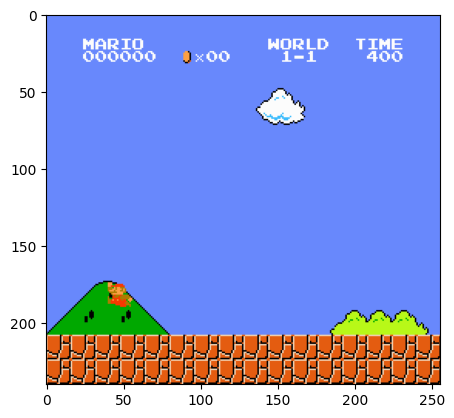

Model sees


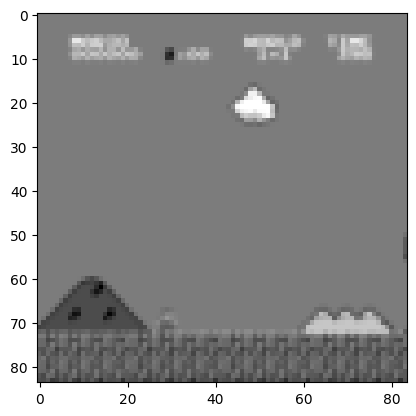

In [10]:
# Output one frame that will feed to model

def visualize_world(test_env):
    obs = test_env.reset()
    for i in range(10):
        action = test_env.action_space.sample()
        obs, reward, done, info = test_env.step(action)

    if obs.shape[0] == 4:
        plt.imshow(obs[-1], cmap='gray')
    else:
        plt.imshow(obs)
    plt.show()
    del test_env

print("Human sees")
visualize_world(gym_super_mario_bros.make(DEFAULT_GAME))

print("Model sees")
visualize_world(build_env())

### Create function to save the animation

In [11]:
# Support method to save GIF to evaluate. Please note we are using best-1-of-20, ideally use average

def save_gif(model, image_file, max_steps=2000):
    best_img = []
    all_rewards = []
    best_reward = 0


    for i in range(20):      # choose 1 best out of 20
        env = build_env()
        _ = env.reset()
        screen = env.render(mode='rgb_array')
        im = Image.fromarray(screen)
        images = [im]
        obs = env.reset()
        cur_best_reward = 0

        for i in range(1, max_steps + 1):
            # Reformat lazyframe to numpy for predict method
            b = torch.Tensor(4, 84, 84)
            torch.stack(obs._frames, out=b)
            action, _ = model.predict(b.numpy())
            # print("action", action)
            obs, reward, done, _ = env.step(action.tolist())
            cur_best_reward += reward
            # Render screen every 8/4 = 2 steps
            if i % 2 == 0:
                screen = env.render(mode='rgb_array')
                images.append(Image.fromarray(screen))
            if done:
                break

        all_rewards.append(cur_best_reward)
        if cur_best_reward > best_reward or (cur_best_reward == best_reward and len(images) > len(best_img)):
            best_reward = cur_best_reward
            best_img = images

    best_img[0].save(image_file, save_all=True, append_images=best_img[1:], loop=0, duration=1)

    print("mean reward of 20 episodes", sum(all_rewards) / len(all_rewards), "\tlength", len(best_img))
    print("saved to", image_file)


### Create directories to store model and videos during training

In [12]:
# Create directory to store models
!mkdir -p "/content/mario_rl/models"

# Create directory to store training videos
!mkdir -p "/content/mario_rl/videos"

### Model

In [13]:
# Instantiate the agent
model = PPO('CnnPolicy', build_env(), verbose=0)

# CnnPolicy -
# There are various policies for different tasks.
# We used CnnPolicy because it works better when it comes to image-based problems.

### Training

In [14]:
base_steps = 0
total_steps = base_steps

for i in range(1, 1 + batches):
    obs = model.env.reset()

    # Train the agent
    model.learn(total_timesteps=each_batch_steps)
    total_steps += each_batch_steps

    if each_batch_steps > 50000:     # only save model if the batch step > 50k
        model.save(f"/content/mario_rl/models/model_{total_steps}")

    save_gif(model, f"/content/mario_rl/videos/model_{total_steps}.gif")


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


mean reward of 20 episodes 730.1 	length 156
saved to /content/mario_rl/videos/model_100.gif
mean reward of 20 episodes 643.5 	length 232
saved to /content/mario_rl/videos/model_200.gif


Load the trained model:

In [17]:
# To use the specific trained model to play Mario

# model.load("checkpoint_zip_path")

### Visualizations

The agent's progress can be seen in the below video.

In [18]:
# Check out model/gif outputs
!ls /content/mario_rl -R

/content/mario_rl:
models	videos

/content/mario_rl/models:

/content/mario_rl/videos:
model_100.gif  model_200.gif



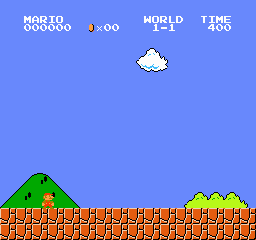

In [19]:
# View the gif
embed.embed_file(f"/content/mario_rl/videos/model_{total_steps}.gif")

### Please answer the questions below to complete the experiment:




In [20]:
# @title  What is the primary objective of policy gradient methods in reinforcement learning? { run: "auto", form-width: "500px", display-mode: "form" }
Answer = "Directly optimize the policy parameters" #@param ["","Maximize the state-action values","Minimize the temporal difference error", " Prioritize exploration over exploitation", "Directly optimize the policy parameters"]

In [21]:
#@title How was the experiment? { run: "auto", form-width: "500px", display-mode: "form" }
Complexity = "Good and Challenging for me" #@param ["","Too Simple, I am wasting time", "Good, But Not Challenging for me", "Good and Challenging for me", "Was Tough, but I did it", "Too Difficult for me"]


In [22]:
#@title If it was too easy, what more would you have liked to be added? If it was very difficult, what would you have liked to have been removed? { run: "auto", display-mode: "form" }
Additional = "good and challenging" #@param {type:"string"}


In [23]:
#@title Can you identify the concepts from the lecture which this experiment covered? { run: "auto", vertical-output: true, display-mode: "form" }
Concepts = "Yes" #@param ["","Yes", "No"]


In [24]:
#@title  Text and image description/explanation and code comments within the experiment: { run: "auto", vertical-output: true, display-mode: "form" }
Comments = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [25]:
#@title Mentor Support: { run: "auto", vertical-output: true, display-mode: "form" }
Mentor_support = "Very Useful" #@param ["","Very Useful", "Somewhat Useful", "Not Useful", "Didn't use"]


In [26]:
#@title Run this cell to submit your notebook for grading { vertical-output: true }
try:
  if submission_id:
      return_id = submit_notebook()
      if return_id : submission_id = return_id
  else:
      print("Please complete the setup first.")
except NameError:
  print ("Please complete the setup first.")

Your submission is successful.
Ref Id: 1156
Date of submission:  02 Aug 2024
Time of submission:  21:25:31
View your submissions: https://aias-iisc.talentsprint.com/notebook_submissions
